In [1]:
# import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Iris Localization

In [2]:
def iris_localization(image, sigma=0.33):
    # Step 0: Convert the image to grayscale and reduce noise using guassian blur
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # gray = cv2.GaussianBlur(gray, (5, 5), 0) # need it when we are using (1) projection + (2) cv2.adaptiveThreshold
    # gray = cv2.equalizeHist(gray)
    ##########################################################################################
    # Step 1: Calculate vertical and horizontal projection to estimate pupil center (Xp, Yp)
    # proj_hori = np.sum(gray, axis=0)  # Sum of pixel intensities along rows
    # proj_vert = np.sum(gray, axis=1)  # Sum of pixel intensities along columns

    # Paper: "The coordinates corresponding to the minima of the two projection profiles are considered as the center coordinates of the pupil."
    # Xp = np.argmin(proj_hori)  # Pupil center in X direction
    # Yp = np.argmin(proj_vert)  # Pupil center in Y direction

    # Revision (not using projections)
    Xp = gray.shape[1] // 2
    Yp = gray.shape[0] // 2
    ##########################################################################################

    ##########################################################################################
    # Step 2: Binarize a 120x120 region around the estimated center (Xp, Yp) with adaptive thresholding
    h, w = gray.shape  # Get image dimensions
    x_min, x_max = max(0, Xp - 60), min(w, Xp + 60)
    y_min, y_max = max(0, Yp - 60), min(h, Yp + 60)
    pupil_region = gray[y_min:y_max, x_min:x_max]  # Interested region around the estimated center (Xp, Yp)


    ## 1st trial: Otsu's method
    # _, binary_pupil_region = cv2.threshold(pupil_region, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    ## 2nd trial
    # Source: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
    binary_pupil_region = cv2.adaptiveThreshold(pupil_region, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    ## 3rd trial
    # binary_pupil_region = cv2.adaptiveThreshold(pupil_region,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    ## 4th trial: Otsu's method after Gaussian filtering
    # blur = cv2.GaussianBlur(pupil_region,(5,5),0)
    # _, binary_pupil_region = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Paper: "The centroid of the resulting binary region (binary_pupil_region) is considered as a more accurate estimate of the pupil coordinates."
    # Refine the pupil center with binary_pupil_region
    M = cv2.moments(binary_pupil_region)
    if M["m00"] != 0:
        refined_Xp = int(M["m10"] / M["m00"]) + x_min
        refined_Yp = int(M["m01"] / M["m00"]) + y_min
    else:
        refined_Xp, refined_Yp = Xp, Yp

    # Paper: "In this binary region, we can also roughly compute the radius of the pupil."
    # ...
    ##########################################################################################

    ##########################################################################################
    # Step 3: Calculate the exact parameters of two circles using Canny edge detection and Hough transformation
    # Construct lower and upper parameters for Canny edge detection
    v = np.median(gray)  # Compute the median of the pixel intensities
    lower = int(max(0, (1.0 - sigma) * v))    # Set the lower threshold
    upper = int(min(255, (1.0 + sigma) * v))  # Set the upper threshold

    # Detect edges with Canny operator
    edges = cv2.Canny(gray, lower, upper)

    # Detect the inner circle (pupil) with HoughCircles
    inner_circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1.5, minDist=50,
                                     param1=50, param2=30, minRadius=20, maxRadius=60)

    # Find the closest inner circle (pupil) to the refined center
    inner_circles = np.round(inner_circles[0, :]).astype("int")
    inner_circle = min(inner_circles, key=lambda c: np.sqrt((c[0] - refined_Xp)**2 + (c[1] - refined_Yp)**2))
    x_inner, y_inner, r_inner = inner_circle

    # Approximate the outer circle radius with the inncer circle radius
    r_outer = int(r_inner*2.4)
    ##########################################################################################

    ##########################################################################################
    # Draw the inner and outer circles as white circles on the original image
    localized_image = image.copy()  # Copy the original image
    cv2.circle(localized_image, (x_inner, y_inner), r_inner, (255, 255, 255), 2)  # White circle for pupil
    cv2.circle(localized_image, (x_inner, y_inner), r_outer, (255, 255, 255), 2)  # White circle for iris
    ##########################################################################################

    ##########################################################################################
    # Create a mask where the outer circle (iris) is white and everything else is black
    mask = np.zeros_like(gray)
    cv2.circle(mask, (x_inner, y_inner), r_outer, 255, thickness=-1)  # White outer circle
    # Apply the mask to the grayscale image to retain only the iris region
    masked_image = cv2.bitwise_and(gray, gray, mask=mask)
    ##########################################################################################

    return localized_image, masked_image, x_inner, y_inner, r_inner, r_outer

([], [])

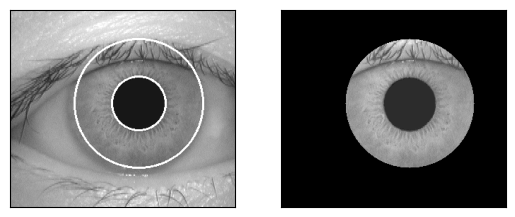

In [3]:
path = "./input"

img_filePath = os.path.join(path, "001/1/001_1_1.bmp")
image = cv2.imread(img_filePath, cv2.IMREAD_GRAYSCALE)
localized_iris_image, masked_iris_image, x_inner, y_inner, r_inner, r_outer = iris_localization(image)

plt.subplot(1,2,1).imshow(localized_iris_image, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2).imshow(masked_iris_image, cmap="gray")
plt.xticks([])
plt.yticks([])

## Iris Normalization

In [4]:
def iris_normalization(image, x_pupil, y_pupil, r_pupil, r_iris, M=64, N=512):
    """
    Map the iris from Cartesian coordinates to polar coordinates.

    Height = Rows  = Y: Each row in the unwrapped donut corresponds to a different "ring" from the center to the edge of the donut.
    Width = Columns = X: Each column corresponds to a different angle as you move around the circumference of the donut (from 0 to 360).

    """
    # Create the output normalized iris image
    I_n = np.zeros((M, N), dtype=np.uint8)    # M: rows, N: cols

    # Loop over each angular and radial position in the normalized image
    for X in range(N): # 512
        # Calculate theta for each angular slice (X value)
        theta = 2 * np.pi * (X / N)

        # For each row (Y) in the normalized image, map corresponding points
        for Y in range(M): # 64
            # Source: https://www.mathsisfun.com/polar-cartesian-coordinates.html
            # Calculate Cartesian coordinate for this (x_p(theta), y_p(theta))
            x_p = x_pupil + (r_pupil * np.cos(theta))
            y_p = y_pupil + (r_pupil * np.sin(theta))
            # Calculate Cartesian coordinate for this (x_i(theta), y_i(theta))
            x_i = x_pupil + (r_iris * np.cos(theta))
            y_i = y_pupil + (r_iris * np.sin(theta))

            # Interpolate the point along the radius from pupil to iris
            x = int(x_p + (x_i - x_p) * (Y / M))
            y = int(y_p + (y_i - y_p) * (Y / M))

            I_n[Y, X] = image[y, x]

    return I_n

([], [])

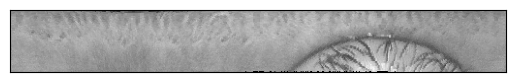

In [5]:
normalized_iris_image = iris_normalization(masked_iris_image, x_inner, y_inner, r_inner, r_outer)

plt.imshow(normalized_iris_image, cmap="gray")
plt.xticks([])
plt.yticks([])

## Iris Enhancement

In [6]:
def enhance_iris_image(normalized_image, block_size_light, block_size_hist):
    ##########################################################################################
    # Step 1: Approximate background illumination (intensity variations)
    M, N = normalized_image.shape

    light_estimate = np.zeros((M//block_size_light, N//block_size_light))
    # Loop through each 16x16 block to calculate the mean value
    for i in range(0, M, block_size_light):
        for j in range(0, N, block_size_light):
            i_step = i // block_size_light
            j_step = j // block_size_light
            block = normalized_image[i:i+block_size_light, j:j+block_size_light]
            light_estimate[i_step, j_step] = np.mean(block)

    # Expend it to the same size as the normalized image by bicubic interpolation
    # Bicubic interpolation algorithm: estimating the color in an image pixel
    #                                  by calculating the average of 16 pixels residing
    #                                  around pixels that are similar to pixels in the source image.
    light_estimate_resized = cv2.resize(light_estimate, (N, M), interpolation=cv2.INTER_CUBIC)
    # print(light_estimate_resized.shape)

    # Subtract from the normalized image to compensate for a variety of lighting conditions
    illum_estimate_image = cv2.subtract(normalized_image, light_estimate_resized.astype(np.uint8))
    ##########################################################################################


    ##########################################################################################
    # Step 2: Apply histogram equalization using 32x32 blocks
    enhanced_image = np.zeros((M, N))

    # Loop through each 32x32 block to apply histogram equalization
    for i in range(0, M, block_size_hist):
        for j in range(0, N, block_size_hist):
            i_range = min(i + block_size_hist, M)
            j_range = min(j + block_size_hist, N)
            block = illum_estimate_image[i:i_range, j:j_range]
            enhanced_image[i:i_range, j:j_range] = cv2.equalizeHist(block.astype(np.uint8))
    ##########################################################################################

    return illum_estimate_image, enhanced_image

([], [])

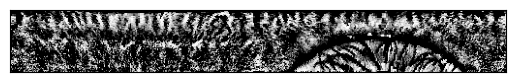

In [7]:
illum_image, enhanced_iris_image = enhance_iris_image(normalized_iris_image, 16, 32)
plt.imshow(enhanced_iris_image, cmap="gray")
plt.xticks([])
plt.yticks([])

## **Feature Extraction**

In [8]:
from FeatureExtraction import FeatureExtractor

In [9]:
# Load a normalized iris image for example
path = "./input"
img_filePath = os.path.join(path, "001/1/001_1_1.bmp")
image = cv2.imread(img_filePath, cv2.IMREAD_GRAYSCALE)

localized_iris_image, masked_iris_image, x_inner, y_inner, r_inner, r_outer = iris_localization(image)
normalized_iris_image = iris_normalization(masked_iris_image, x_inner, y_inner, r_inner, r_outer)
illum_image, enhanced_iris_image = enhance_iris_image(normalized_iris_image, 16, 32)

feature_extractor = FeatureExtractor(enhanced_iris_image)
features = feature_extractor.extract_features()

print("Extracted features:", features)
print("Feature Vector Length:", len(features))
print("Feature Vector Sample:", features[:10])  # Display first 10 features for brevity

Extracted features: [6.009213, 10.621319, 12.136299, 13.418339, 6.9189477, 12.576464, 6.339565, 9.726016, 7.034357, 12.274444, 9.608289, 11.612452, 13.724674, 19.508121, 11.313107, 19.857674, 11.827705, 16.628023, 14.079481, 21.670029, 15.419927, 23.27113, 9.795973, 14.120525, 7.929699, 13.83301, 5.000281, 7.9560356, 7.574407, 13.500556, 5.04657, 8.458521, 9.347059, 15.772396, 8.81168, 14.870617, 8.085355, 13.933704, 9.249786, 14.368005, 7.3477764, 11.3716755, 7.268764, 11.23016, 12.137493, 19.284683, 8.785488, 14.755498, 6.5104036, 10.103699, 5.883419, 10.720846, 9.831458, 14.814405, 12.605904, 17.006638, 10.90016, 16.836166, 6.0201807, 12.040361, 8.045743, 11.259869, 9.938398, 16.182812, 8.856967, 14.554751, 10.899901, 17.726706, 8.340263, 13.474695, 9.178089, 15.168125, 13.074871, 20.739992, 14.1990385, 22.793541, 6.9624157, 10.056894, 8.53577, 12.349193, 10.392641, 16.197746, 6.641291, 11.854677, 9.461137, 15.378958, 10.96903, 18.809988, 6.9899435, 8.739688, 8.477921, 13.196563, 8.

## **Results**

([], [])

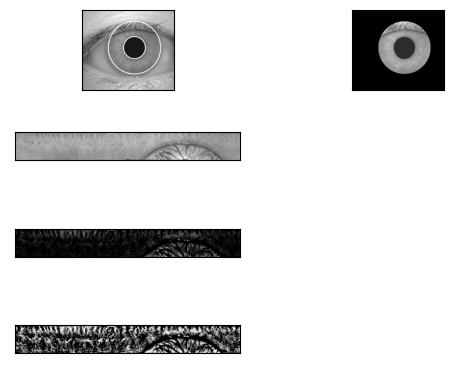

In [10]:
# Load image
path = "./input"

# Preprocess image
img_filePath = os.path.join(path, "001/1/001_1_1.bmp")
image = cv2.imread(img_filePath, cv2.IMREAD_GRAYSCALE)
localized_iris_image, masked_iris_image, x_inner, y_inner, r_inner, r_outer = iris_localization(image)
normalized_iris_image = iris_normalization(masked_iris_image, x_inner, y_inner, r_inner, r_outer)
illum_image, enhanced_iris_image = enhance_iris_image(normalized_iris_image, 16, 32)

# Plot results
plt.subplot(4,2,1).imshow(localized_iris_image, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.subplot(4,2,2).imshow(masked_iris_image, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.subplot(4,2,3).imshow(normalized_iris_image, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.subplot(4,2,5).imshow(illum_image, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.subplot(4,2,7).imshow(enhanced_iris_image, cmap="gray")
plt.xticks([])
plt.yticks([])

## **Others**

In [ ]:
# I_n = np.zeros((5, 5), dtype=np.uint8)
# I_n[2,1] = 1 # (1,2)
# I_n

In [ ]:
# def iris_normalization_other(image, x_pupil, y_pupil, r_pupil, r_iris, M=64, N=512):
#     """
#     Map the iris from Cartesian coordinates to polar coordinates.

#     Height = Rows  = Y: Each row in the unwrapped donut corresponds to a different "ring" from the center to the edge of the donut.
#     Width = Columns = X: Each column corresponds to a different angle as you move around the circumference of the donut (from 0 to 360).

#     """
#     # Create the output normalized iris image
#     I_n = np.zeros((M, N), dtype=np.uint8)

#     # Loop over each row (radial distance Y) in the normalized image
#     for Y in range(M):     # 64
#         # Calculate Cartesian coordinates for both the pupil and iris boundaries
#         for X in range(N): # 512
#             # Calculate theta for each angular slice (X value)
#             theta = 2 * np.pi * X / N

#             # Source: https://www.mathsisfun.com/polar-cartesian-coordinates.html
#             # Calculate Cartesian coordinate for this (x_p(theta), y_p(theta))
#             x_p = x_pupil + (r_pupil * np.cos(theta))
#             y_p = y_pupil + (r_pupil * np.sin(theta))
#             # Calculate Cartesian coordinate for this (x_i(theta), y_i(theta))
#             x_i = x_pupil + (r_iris * np.cos(theta))
#             y_i = y_pupil + (r_iris * np.sin(theta))

#             # Interpolate the point along the radius from pupil to iris
#             x = int(x_p + (x_i - x_p) * (Y / M))
#             y = int(y_p + (y_i - y_p) * (Y / M))

#             I_n[Y, X] = image[y, x]

#     return I_n

# image = cv2.imread(img_filePath, cv2.IMREAD_GRAYSCALE)
# normalized_iris = iris_normalization_other(masked_iris_image, x_inner, y_inner, r_inner, r_outer)

# plt.imshow(normalized_iris, cmap="gray")